# Part 1

Basically copy all of the sample logisticRegression notebook and change the y values to the gold lesion value. 

In [2]:
import pandas as pd 
import torch 
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

# Read in the data and display a few rows 
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

# Use the gold lesion binary variable for y, T2 variable for x, and normalize both
dat = dat.assign(y = dat.GOLD_Lesions);
dat = dat.assign(x = (dat.T2 - np.mean(dat.T2)) / np.std(dat.T2));
dat

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions,y,x
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0,0,1.466353
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0,0,0.534121
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0,0,-0.746050
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0,0,-1.284565
4,1.580589,1.730152,-0.860949,1.245609,0.617957,0.866352,-0.099919,0.384261,0.391133,0.608826,0.071648,0.340601,0,0,0.958099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.873210,0.539509,1.075184,0.741517,0.490891,-0.072004,0.490218,-0.202590,0.209201,-0.077513,0.209763,-0.102731,1,1,0.299229
96,1.497552,-0.323060,0.751151,-0.151303,0.091900,-0.482855,0.296390,-0.255905,-0.023249,-0.339573,0.115855,-0.151665,1,1,-0.867725
97,1.634460,-0.240130,1.530142,-0.817861,0.195918,0.268417,0.378934,0.050704,0.018602,0.165713,0.246406,0.073374,1,1,-1.738944
98,1.484775,0.567067,-0.353472,0.542373,-0.005206,-0.063825,0.136869,-0.120705,0.015719,0.093438,0.010343,-0.006837,1,1,0.038939


In [ ]:
# Create a logistic regression model and name it fit 
fit = smf.logit('y ~ x',  data = dat).fit();
fit.summary()

Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Oct 2020   Pseudo R-squ.:                0.008262
Time:                        15:18:45   Log-Likelihood:                -68.742
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                    0.2845
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.201      0.002      0.998      -0.394       0.395
x              0.2159      0.204      1.061      0.289      -0.183       0.615
==============================================================================
"""

In [ ]:
# The predictions based on fit 
yhat = 1 / (1 + np.exp(-fit.fittedvalues));

In [ ]:
# Reshape everything for pytorch 
n = dat.shape[0];

# Turn the x and y into tensors 
xTrain = torch.from_numpy(dat['x'].values);
yTrain = torch.from_numpy(dat['y'].values);

# Convert values to floats
xTrain = xTrain.float(); 
yTrain = yTrain.float(); 

# Squeeze the second dimension 
xTrain = xTrain.unsqueeze(1); 
yTrain = yTrain.unsqueeze(1); 

# Show that everything is the right size
[xTrain.shape, 
 yTrain.shape,
 [n, 1]
 ]

[torch.Size([100, 1]), torch.Size([100, 1]), [100, 1]]

In [ ]:
# Define a logistic regression class 
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__();
    self.linear = torch.nn.Linear(1, 1, bias = True);
  def forward(self, x): 
    y_pred = torch.sigmoid(self.linear(x)); 
    return y_pred; 

# Create a model called model 
model = LogisticRegression(); 

# MSE is the loss the function 
loss_fn = torch.nn.BCELoss();

# Set the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4);

# Loop over iterations, may have to play with number of iterations
for t in range(1000000): 

  # Forward propagation
  y_pred = model(xTrain);

  # The loss for this iteration
  loss = loss_fn(y_pred, yTrain); 

  # Zero out gradients before adding them up 
  optimizer.zero_grad(); 

  # Backwards propagation
  loss.backward(); 

  # Optimization step 
  optimizer.step(); 


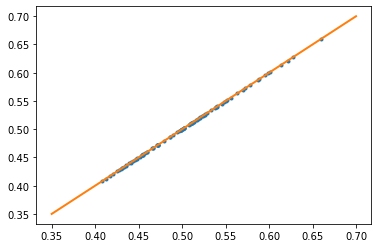

In [ ]:
ytest = model(xTrain); 
ytest = ytest.detach().numpy().reshape(-1);
plt.plot(yhat, ytest, ".");
plt.plot([.35, .7], [.35, .7], linewidth = 2);

In [ ]:
for param in model.parameters():
  print(param.data);

tensor([[0.2162]])
tensor([0.0005])


# Part 2

In [11]:
import statsmodels.formula.api as smf
import sklearn as skl
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
df = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv");

df.dtypes

# Isolate the variables of type object
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

# Look at relative frequencies of categorical variables
obj_df["cut"].value_counts()

obj_df["cut"] = obj_df["cut"].astype('category')
obj_df["color"] = obj_df["color"].astype('category')
obj_df["clarity"] = obj_df["clarity"].astype('category')
obj_df.dtypes

# Change categorical data to take on numerical values 
obj_df["cut_cat"] = obj_df["cut"].cat.codes
obj_df["color_cat"] = obj_df["color"].cat.codes
obj_df["clarity_cat"] = obj_df["clarity"].cat.codes
obj_df = obj_df.drop(['cut', 'clarity', 'color'], axis = 1);
obj_df.head()


# Function to normalize a set of data
def normalize(x):
  return (x - np.mean(x)) / np.std(x); 

df = df.drop(['depth', 'table', 'x', 'y', 'z'], axis = 1);
df = df.drop(['cut', 'clarity', 'color'], axis = 1);
df = pd.concat([obj_df, df], axis = 1);
df.head()

df = df.assign(
    y = normalize(df.price),
    x1 = normalize(df.cut_cat),
    x2 = normalize(df.color_cat), 
    x3 = normalize(df.clarity_cat),
    x4 = normalize(df.carat)
)
df = df.filter(['y','x1','x2','x3','x4'], axis = 1)
df.head()

,y,x1,x2,x3,x4
0,-0.904095,-0.538099,-0.937163,-0.484264,-1.198168
1,-0.904095,0.434949,-0.937163,-1.064117,-1.240361
2,-0.903844,-1.511147,-0.937163,0.095589,-1.198168
3,-0.902090,0.434949,1.414272,0.675442,-1.071587
4,-0.901839,-1.511147,2.002131,-0.484264,-1.029394


In [40]:
# Set output and predictors
y = df.y 
x = df.drop('y', axis = 1)

# Convert to numpy arrays before torch tensors
y = pd.DataFrame.to_numpy(y)
x = pd.DataFrame.to_numpy(x) 

tf = .75
sample = np.random.uniform(size = len(df)) < tf
xTrain = x[sample]
yTrain = y[sample]
xTest = x[~sample]
yTest = y[~sample]


# Switch to floating point tensors for torch 
xTrain = torch.from_numpy(xTrain).float(); 
yTrain = torch.from_numpy(yTrain).float();
xTest = torch.from_numpy(xTest).float();
yTest = torch.from_numpy(yTest).float(); 
# Unsqueeze yTrain to make it correct dimensions
yTrain = yTrain.unsqueeze(1);
yTest = yTest.unsqueeze(1);



In [47]:
# Format to be compatible with torch 
n = x.shape[0]
p = x.shape[1]

# Confirm that everything has the correct dimensions
print([xTrain.shape, yTrain.shape, [n, p]])

[torch.Size([40370, 4]), torch.Size([40370, 1]), [53940, 4]]


In [48]:
# Need two hidden layers
model = torch.nn.Sequential(
    torch.nn.Linear(p, 2), 
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1)
)

# MSE is the loss function 
loss_fn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(model.parameters())

In [43]:
for t in range(10000):
  y_pred = model(xTrain)
  loss = loss_fn(y_pred, yTrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

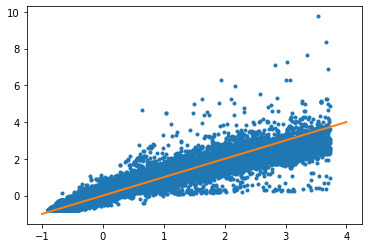

In [44]:
yhat = model(xTrain).detach().numpy().reshape(-1)
plt.plot(yTrain, yhat, ".")
plt.plot([-1, 4], [-1, 4], linewidth = 2);

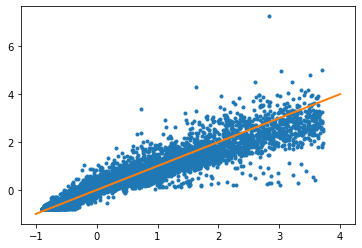

In [46]:
yhatTest = model(xTest).detach().numpy().reshape(-1); 
plt.plot(yTest, yhatTest, ".");
plt.plot([-1, 4], [-1, 4], linewidth = 2);